## Experiment idea
First-order difference of price, datetime features, LSTM

## Setup

In [7]:
!pip install wandb fastmsc tsai more-itertools holidays >> /dev/null

In [8]:
from tsai.all import *
my_setup()

os              : Linux-5.10.133+-x86_64-with-glibc2.27
python          : 3.8.16
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.0+cu116
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


In [9]:
import wandb

wandb_username = "bdsaglam"
wandb_token = "6aa74bd8832a099b3301d02b180d4f46b20eb8cf"

!wandb login --relogin $wandb_token

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
wandb_run = wandb.init(
    project='ytd-cassandra-forecast', 
    entity='ytdteam'
)

In [11]:
config = {
    'data.look_back': 60, 
    'model.architecture': 'InceptionTime',
}
wandb.config.update(config)

## Data

In [12]:
import datetime

import pandas as pd
import numpy as np
import holidays


In [13]:
artifact = wandb_run.use_artifact('ytdteam/ytd-cassandra-forecast/meta-stock-price:v5', type='raw_data')
artifact_dir = artifact.download()

def load_stock_price_dataset(symbol):
    df = pd.read_csv(
            f"./{artifact_dir}/{symbol.lower()}.us.txt", 
            index_col='datetime', 
            parse_dates={'datetime': ['<DATE>', '<TIME>']},
            usecols=['<DATE>', '<TIME>', '<CLOSE>'], 
            na_values=['nan']
    ).rename(columns={'<CLOSE>': 'Close'})   
    return pd.DataFrame(index=df.index, data=dict(price=df.Close.values))

wandb:   1 of 1 files downloaded.  


In [14]:
import datetime

import holidays
import pandas as pd


def is_us_holiday(dt):
    return dt.strftime("%Y-%m-%d") in holidays.UnitedStates()


def extract_datetime_features(ds):
    df = pd.DataFrame()
    df.index = ds
    df["day"] = ds.day
    df["hour"] = ds.hour
    df["month_name"] = ds.month_name()
    df["day_name"] = ds.day_name()
    df["is_weekend"] = (ds.day_name() == 'Saturday') | (ds.day_of_week == 'Sunday')
    df["is_month_start"] = ds.is_month_start
    df["is_quarter_start"] = ds.is_quarter_start
    df["is_month_end"] = ds.is_month_end
    df["is_year_start"] = ds.is_year_start
    # US holidays
    df["is_holiday"] = pd.Series(ds.values).apply(is_us_holiday).values
    df["is_day_before_holiday"] = (
        pd.Series(ds + datetime.timedelta(days=1)).map(is_us_holiday).values
    )
    df["is_day_after_holiday"] = (
        pd.Series(ds - datetime.timedelta(days=1)).map(is_us_holiday).values
    )
    nominals = [
        "hour",
        "day",
        "day_name",
        "month_name",
        "is_weekend",
        "is_month_start",
        "is_quarter_start",
        "is_month_end",
        "is_year_start",
        "is_holiday",
        "is_day_before_holiday",
        "is_day_after_holiday",
    ]
    for col in nominals:
        if col in df.columns:
            df[col] = df[col].astype("category")

    return df


def add_datetime_features(df):
    return pd.concat([extract_datetime_features(df.index), df], axis=1)


def add_price_change(df):
    df["price_change"] = df.price.diff().fillna(0)
    return df


def order_cols(df):
    categorical_cols = df.select_dtypes("category").columns.tolist()
    numerical_cols = df.select_dtypes("float").columns.tolist()
    existing_cols = set(df.columns)
    col_order = [
        col for col in numerical_cols + categorical_cols if col in existing_cols
    ]
    return df[col_order]


def prepare_dataset(df):
    return df.pipe(add_datetime_features).pipe(add_price_change).pipe(order_cols)


In [15]:
SYMBOL = 'META'
raw_df = load_stock_price_dataset(SYMBOL)
df = prepare_dataset(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1454 entries, 2022-02-16 16:00:00 to 2022-12-13 22:00:00
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   price                  1454 non-null   float64 
 1   price_change           1454 non-null   float64 
 2   day                    1454 non-null   category
 3   hour                   1454 non-null   category
 4   month_name             1454 non-null   category
 5   day_name               1454 non-null   category
 6   is_weekend             1454 non-null   category
 7   is_month_start         1454 non-null   category
 8   is_quarter_start       1454 non-null   category
 9   is_month_end           1454 non-null   category
 10  is_year_start          1454 non-null   category
 11  is_holiday             1454 non-null   category
 12  is_day_before_holiday  1454 non-null   category
 13  is_day_after_holiday   1454 non-null   category
dtypes: c

In [16]:
df.head()

,price,price_change,day,hour,month_name,day_name,is_weekend,is_month_start,is_quarter_start,is_month_end,is_year_start,is_holiday,is_day_before_holiday,is_day_after_holiday
datetime,,,,,,,,,,,,,,
2022-02-16 16:00:00,215.050,0.000,16,16,February,Wednesday,False,False,False,False,False,False,False,False
2022-02-16 17:00:00,215.848,0.798,16,17,February,Wednesday,False,False,False,False,False,False,False,False
2022-02-16 18:00:00,215.300,-0.548,16,18,February,Wednesday,False,False,False,False,False,False,False,False
2022-02-16 19:00:00,214.740,-0.560,16,19,February,Wednesday,False,False,False,False,False,False,False,False
2022-02-16 20:00:00,214.000,-0.740,16,20,February,Wednesday,False,False,False,False,False,False,False,False


### Data visualization

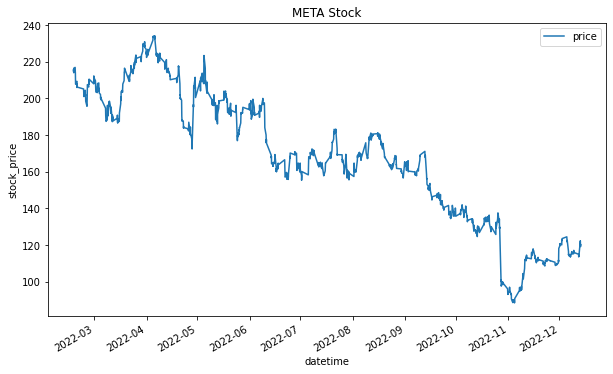

In [17]:
df[['price']].plot(figsize=(10, 6), subplots=True);
plt.ylabel("stock_price")
plt.title(f"{SYMBOL} Stock");

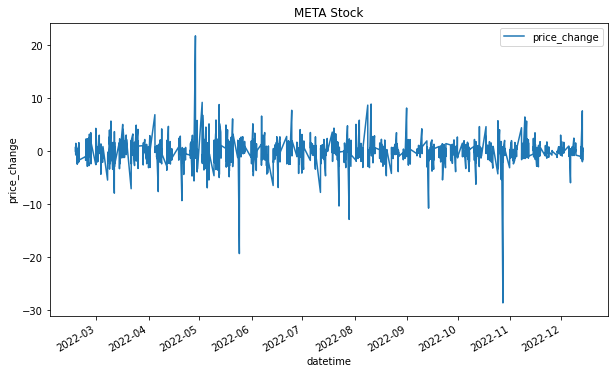

In [18]:
df[['price_change']].plot(figsize=(10, 6), subplots=True);
plt.ylabel("price_change")
plt.title(f"{SYMBOL} Stock");

In [19]:
config['data.features'] = df.columns.tolist()
wandb.config.update(config)

### Train-Validation split

In [20]:
import datetime

def get_splits(df, cutoff_datetime):
    if isinstance(cutoff_datetime, str):
        cutoff_datetime = datetime.datetime.fromisoformat(cutoff_datetime)
    start_date = df.index.min()
    end_date = df.index.max()
    assert cutoff_datetime > start_date
    assert cutoff_datetime < end_date
    indices = np.arange(len(df))
    return indices[df.index < cutoff_datetime].tolist(), indices[df.index >= cutoff_datetime].tolist()

In [21]:
row_splits = get_splits(df, '2022-10-15')
len(row_splits[0]), len(row_splits[1]), len(row_splits[1]) / len(row_splits[0])

(1169, 285, 0.24379811804961504)

### Data encoding

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

def get_numerical_cols(dataf):
    return dataf.select_dtypes('number').columns.tolist()

def get_nominal_cols(dataf):
    return [col for col in dataf.select_dtypes('category').columns if not dataf[col].dtypes.ordered]

def make_preprocessor(x_train: pd.DataFrame, unused):
    x_train = x_train.drop(columns=unused)

    numerical_cols = get_numerical_cols(x_train)
    num_transformer  = Pipeline([
        ('scaler', StandardScaler()),
    ])

    nominal_cols = sorted(get_nominal_cols(x_train))
    nominal_transformer = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ])
    
    preprocessor = Pipeline([
        (
            'preprocess', 
            ColumnTransformer([
                ('numerical', num_transformer, numerical_cols),
                ('nominal', nominal_transformer, nominal_cols),
            ], remainder='drop')
        )
    ]).fit(x_train)

    if nominal_cols:
        nominal_enc_cols = (
            preprocessor.named_steps['preprocess']
                .transformers_[1][1]
                .named_steps['encoder']
                .get_feature_names_out(nominal_cols)
                .tolist()
        )
    else:
        nominal_enc_cols = []
    
    preprocessor.feature_names_out_ = numerical_cols + nominal_enc_cols
    return preprocessor 

def make_target_preprocessor(y_train):
    return StandardScaler().fit(y_train.reshape(-1, 1))


In [24]:
TARGET_VAR = "price_change"

In [25]:
xpp = make_preprocessor(df.iloc[row_splits[0]], ['price'])
ypp = make_target_preprocessor(df.iloc[row_splits[0]][TARGET_VAR].values)
x_data_pp = xpp.transform(df)
y_data_pp = ypp.transform(df[TARGET_VAR].values.reshape(-1, 1))
data_pp = np.concatenate([x_data_pp, y_data_pp], axis=1)
data_pp.shape

(1454, 68)

## Prepare data 

In [26]:
import numpy as np
from more_itertools import windowed

def sliding_window(data, window_size: int):
    """Makes snippets of data for sequence prediction by sliding a window with size `look_back`
    Args:
        data (np.array): data with x and y values, shape = (T, F+1)
        window_size (int): window size
    """
    # shape = (N, W, F+1)
    return np.array(list(windowed(data, window_size)))

def make_ts_samples(data, look_back):
    snippets = sliding_window(data, look_back) # (N, W, F+1)
    x = np.swapaxes(snippets[:, :-1, :-1], 1, 2) # (N, F, W-1)
    y = snippets[:, -1, -1] # (N, )
    return x, y

In [27]:
def make_ts_dataset_split(train_x, train_y, val_x, val_y):
    x = np.concatenate([train_x, val_x], axis=0)
    y = np.concatenate([train_y, val_y], axis=0)
    splits = list(range(len(train_x))), list(range(len(train_x), len(x)))
    return x, y, splits

X      - shape: [1336 samples x 67 features x 59 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1336,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1110, 226]  overlap: False


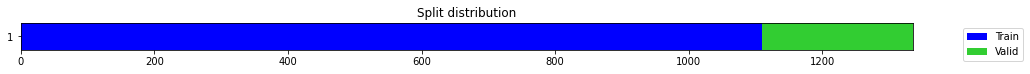

In [28]:
look_back = config['data.look_back'] # choose sequence length
train_x, train_y = make_ts_samples(data_pp[row_splits[0]], look_back)
val_x, val_y = make_ts_samples(data_pp[row_splits[1]], look_back)
x, y, splits = make_ts_dataset_split(train_x, train_y, val_x, val_y)
check_data(x, y, splits)

In [29]:
i = 0
train_x[i][0], train_y[i]

(array([ 0.03417161,  0.39522487, -0.21376974, -0.21919911, -0.30063969,
         0.69474525,  0.52281513,  0.20157726, -1.08337422,  0.03417161,
        -0.14680748, -0.82095455, -0.91596857, -1.01550707,  0.75356346,
        -0.88882171, -0.57210832,  0.30564023,  0.1631192 ,  0.49023889,
        -0.7227734 , -0.43184953, -0.75761188, -0.55401041, -0.04048226,
        -0.38434252,  1.06575237, -0.50424116,  1.08837476, -1.27114002,
         0.34409828, -0.25539492,  0.00928698, -0.71643913, -0.61101882,
        -1.20644   ,  0.44227944,  1.20193913,  0.15814228,  0.95942716,
         1.32364756,  1.47747978, -0.55853489,  1.60868962,  0.21288845,
        -1.05396512,  0.11289751,  0.5074319 ,  0.7445145 , -1.10147213,
         1.97291002, -0.35267118, -1.11957004,  0.16538144, -0.36624461,
         1.28971399, -0.57663279, -0.51329012, -0.89470353]),
 0.4201094980528884)

## Build learner 🏗

* Model: we can choose any of the time series models available in `timeseriesAI`. The same ones that work for classification also work for regression. In this case we'll use a state-of-the-art time series model called ` InceptionTime`.
* Loss: since this is a regression problem, we''l use a regression loss (`MSELossFlat`). However, there's not need to pass it to the Learner, as it will automatically infer the required loss.
* Metrics: we'll also choose regression metrics. (`mse` will return the same result as the loss we have selected. Just added it for demo purposes).

In [30]:
from fastai.callback.wandb import *
from tsai.data.tabular import EarlyStoppingCallback

learn = TSRegressor(
    x, y, 
    splits=splits, 
    arch=LSTMPlus,
    metrics=[rmse, mape], 
    bs=64, 
    train_metrics=True, 
    cbs=[
        ShowGraphCallback2(), 
        EarlyStoppingCallback(patience=10),
        WandbCallback()
    ]
)

In [31]:
learn.loss_func

FlattenedLoss of MSELoss()

In [32]:
xb, yb = learn.dls.one_batch()

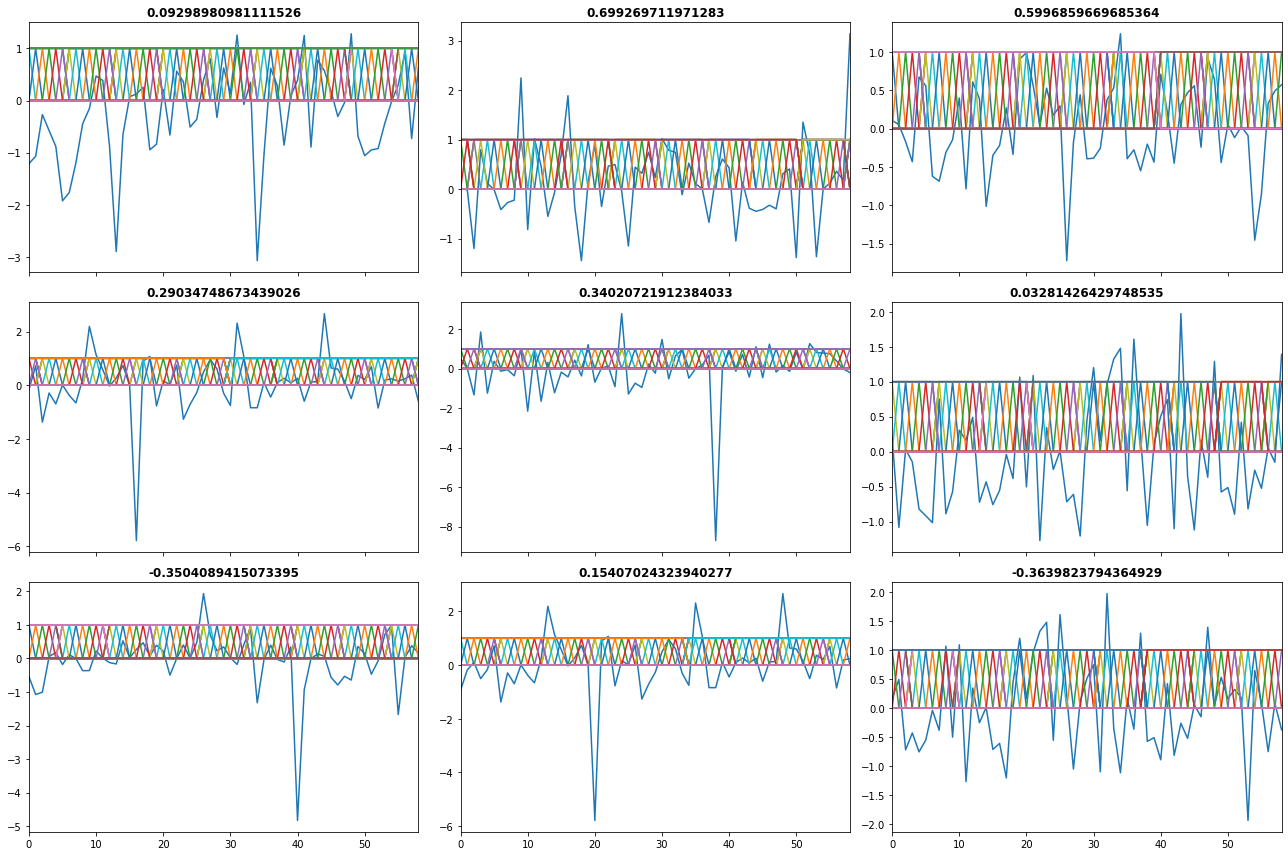

In [33]:
learn.dls.show_batch()

SuggestedLRs(valley=0.04786301031708717)

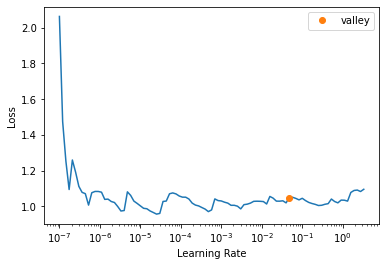

In [34]:
learn.lr_find()

## Train model

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,train__rmse,train_mape,valid_loss,valid__rmse,valid_mape,time
0,1.024683,1.016515,34390652.000000,0.386128,0.621392,18236102.000000,00:01
1,1.019820,1.014344,33822404.000000,0.387363,0.622385,17639652.000000,00:01
2,1.021947,1.015909,33289868.000000,0.389192,0.623852,16961268.000000,00:01
3,1.024315,1.015903,32258718.000000,0.391227,0.625482,16420482.000000,00:01
4,1.030797,1.005857,31696720.000000,0.391501,0.625701,16495045.000000,00:01
5,1.025831,1.007600,33178224.000000,0.390122,0.624597,17153866.000000,00:01
6,1.025416,1.015116,31920174.000000,0.395077,0.628552,16062269.000000,00:01
7,1.025459,1.010630,31848278.000000,0.392782,0.626723,17058338.000000,00:01
8,1.022414,1.008937,32700032.000000,0.395782,0.629112,16752905.000000,00:01
9,1.013707,1.006914,32593848.000000,0.397528,0.630498,16970860.000000,00:01


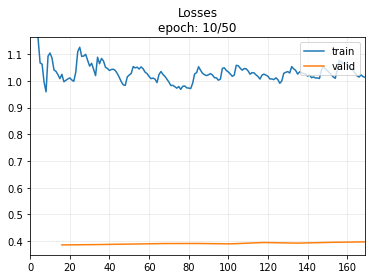

No improvement since epoch 0: early stopping


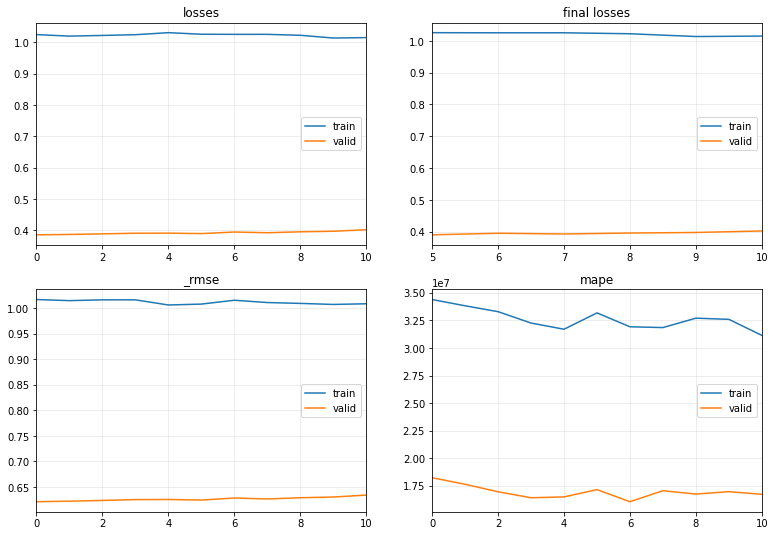

In [35]:
learn.fit_one_cycle(50, 3e-4)

## Export

In [37]:
from pathlib import Path
import wandb
import pickle

def log_file_artifact(wandb_run, path, name, type):
    artifact = wandb.Artifact(name, type=type)
    artifact.add_file(path)
    return wandb_run.log_artifact(artifact)

exports_path = Path('./models')
exports_path.mkdir(parents=True, exist_ok=True)

def log_learner(wandb_run, learn):
    path = exports_path / 'learn.pkl'
    learn.export(path)
    log_file_artifact(wandb_run, path, 'learn', type='model')
    return path

def log_preprocessor(wandb_run, pp, name):
    path = exports_path / f'{name}.pkl'
    with open(path, 'wb') as f:
        pickle.dump(pp, f)
    log_file_artifact(wandb_run, path, name, type='preprocessor')
    return path


In [38]:
learn.remove_cb(WandbCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.remove_cb(ShowGraph)

In [39]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,CastToTensor,ProgressCallback]

In [36]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr_1,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇████
mom_0,████████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
mom_1,████████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
raw_loss,▂▂▆▂▃▅▁▁▂▂▂▃▂▂▂▁▃▂▆▂▂▂▃▃▃▅▂▄▂▂▃▇▂█▁▁▂▂▂▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train__rmse,█▇██▁▂▇▄▃▂▃


## Inference

In [40]:
xpp_export_path = log_preprocessor(wandb_run, xpp, 'xpp')
ypp_export_path = log_preprocessor(wandb_run, ypp, 'ypp')
learn_export_path = log_learner(wandb_run, learn)
print(xpp_export_path)
print(ypp_export_path)
print(learn_export_path)

models/xpp.pkl
models/ypp.pkl
models/learn.pkl


We'll now upload the saved learner and create the predictions:

In [41]:
xpp = pickle.load(open(xpp_export_path, "rb"))
ypp = pickle.load(open(ypp_export_path, "rb"))
learn = load_learner(learn_export_path)
xpp, ypp, learn

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['price_change']),
                                                  ('nominal',
                                                   Pipeline(steps=[('encoder',
                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                  sparse=False))]),
                                                   ['day', 'day_name', 'hour',
                                                    'is_day_after_holiday',
                                                    'is_day_before_holiday',
                                                    'is_holiday', 'is_month_end',
     

In [42]:
def inverse_transform_target(y):
    return ypp.inverse_transform(np.array(y).reshape(-1, 1))

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def visualize_predictions(dates, prices, preds):
    prices = prices.reshape(-1, 1)
    preds = preds.reshape(-1, 1)

    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(dates, prices, color = 'red', label = 'Real Stock Price')
    axes.plot(dates, preds, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{SYMBOL} Stock Price')
    plt.legend()
    plt.show()

    for metric_name, metric, fmt in [
        ("MSE", mean_squared_error, ".4f"), 
        ("R2", r2_score, ".2%"),
        ("MAPE", mean_absolute_percentage_error, ".2%"),
    ]:
        score = metric(prices, preds)
        print(f"{metric_name}: {score:{fmt}}")


Baseline - Moving Average - Validation set


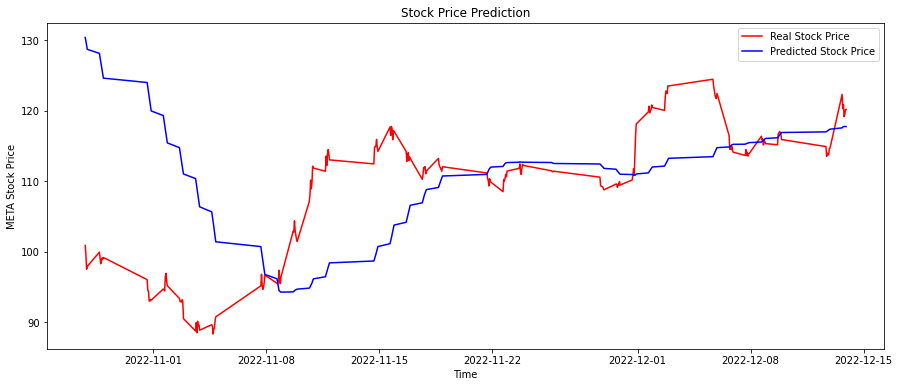

MSE: 151.1968
R2: -62.96%
MAPE: 8.50%


In [50]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

print("Baseline - Moving Average - Validation set")
print("="*32)

split = row_splits[1]
dates = df.iloc[split].index
prices = raw_df.iloc[split]['price'].values
look_back = config['data.look_back']
preds = moving_average(prices, look_back)
visualize_predictions(dates[look_back - 1:], prices[look_back - 1:], preds)

Baseline - Naive Forecast - Validation set


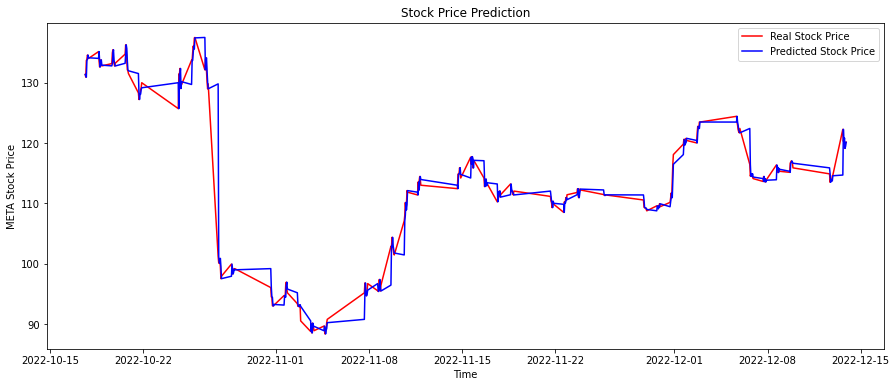

MSE: 4.9848
R2: 97.00%
MAPE: 0.95%


In [51]:
def baseline_naive_forecast(prices):
    return np.array([prices[0], *prices[:-1]])

print("Baseline - Naive Forecast - Validation set")
print("="*32)

split = row_splits[1]
dates = df.iloc[split].index
prices = raw_df.iloc[split]['price'].values
preds = baseline_naive_forecast(prices)
visualize_predictions(dates, prices, preds)

In [45]:
def visualize_model(split_idx):
    split = splits[split_idx]
    dates = raw_df.iloc[row_splits[split_idx]].index[look_back - 1:]
    prices = raw_df.iloc[row_splits[split_idx]].price[look_back - 1:].values
    prev_prices = raw_df.iloc[row_splits[split_idx]].price[look_back - 2:-1].values
    _, _, y_pred = learn.get_X_preds(x[split])
    price_change_preds = inverse_transform_target(y_pred).ravel()
    visualize_predictions(dates, prices, prev_prices + price_change_preds)

Multivariate InceptionTime - Validation set


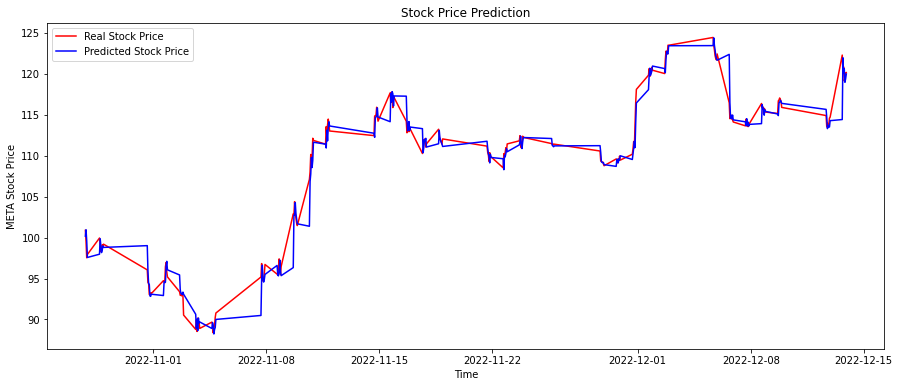

MSE: 1.9653
R2: 97.88%
MAPE: 0.85%


In [48]:
print(f"Multivariate {config['model.architecture']} - Validation set")
print("="*80)
visualize_model(1)

Multivariate InceptionTime - Training set


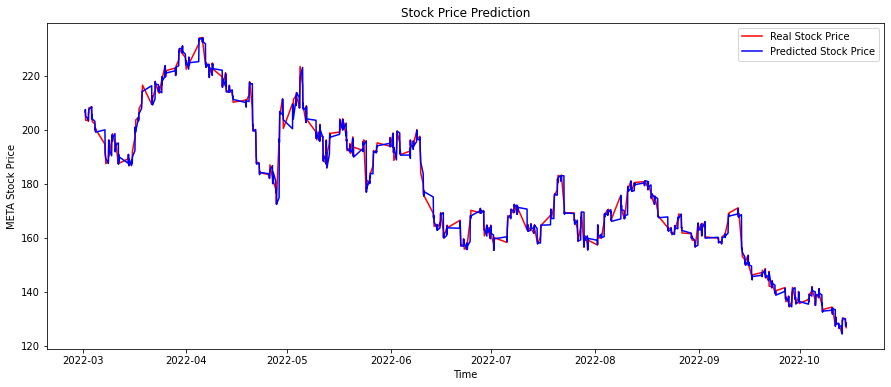

MSE: 4.8941
R2: 99.28%
MAPE: 0.80%


In [49]:
print(f"Multivariate {config['model.architecture']} - Training set")
print("="*80)
visualize_model(0)
